# DeFi-CeFi arbitrage-strategy-walk-through

### Created by Albert Yao 


## Structure


* **Goal of the project**
>            1. Leverage Amberdata DeFi API to build backtest framework for Defi/Cefi arbitrage 
             2. Understand the potential arbitrage profit by using uniswap v2 equation
             

* **Overview of the dex/cex price**   
>            1. Visualize the dex/cex price difference and create entry signal for arbitrage
* **Arbitrage Time window analysis** 
>            1. Table for time window
             2. Multi-plot of price difference and time window
* **Introduction to Uniswap v2 equation** 
>            1. Uniswap v2 math equation walk-through
             2. Swap function with fee in python 
             2. Stress test on v2 swap equation with Amberdata liquidity API 
* **Strategy codebase** 
>            1.Strategy framework design 
             2.Customized strategy on buy/sell condition 
             
* **Strategy Dashboard** 
>            1.Cumulative PnL, PnL %, entry/exit time 
* **Strategy Trade analysis** 
>            1.Detail PnL analysis based on day/hour  
             2.Gas fee per trade tracker
             3.Sharp, Sortino Ratio, SQN 



                 

In [81]:
import requests
import json
import pandas as pd
from datetime import datetime
import numpy as np
import plotly.express as px
from io import StringIO ## for Python 3
import quantstats as qs

from dotenv import load_dotenv # use for api key 
import os #provides ways to access the Operating System and allows us to read the environment variables


## run code for existing merged cex/dex data start from here


In [82]:
df_cex_dex = pd.read_csv('amber_merge_data_new.csv', index_col=0)

df_cex_dex.head()


,timestamp,cex_price,dex_price,token0Amount,token1Amount,datetime
390135,1643691658000,2746.175304,2747.714408,9.909518e+07,36064.585536,2022-02-01 00:00:58
45772,1643691660000,2747.518422,2747.714408,9.909518e+07,36064.585536,2022-02-01 00:01:00
390136,1643691679000,2747.518422,2749.652800,9.913018e+07,36051.890360,2022-02-01 00:01:19
45773,1643691720000,2747.143086,2749.652800,9.913018e+07,36051.890360,2022-02-01 00:02:00
390138,1643691757000,2747.143086,2749.081728,9.911990e+07,36055.640360,2022-02-01 00:02:37


## Overview of dex/cex price 

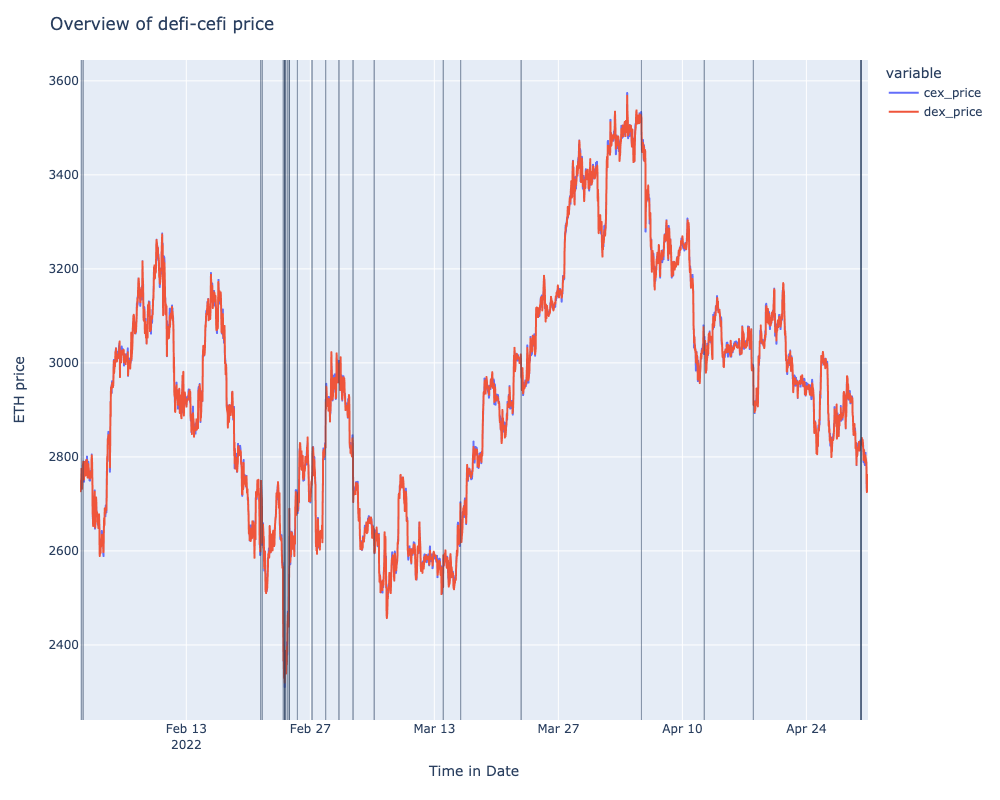

0

In [83]:
import plotly.express as px

def plot_specific(df, d, start, end, step, file):
    
    """ A function to plot the plot the price difference between cex and dex
            

    Keyword arguments:
    d -- input parameter to check the price difference %, if above the threshold, will be treated as entry signal
    start,end -- input start/end time in date to check transactions
    step -- input parameter to contorl how many rows being ignored (if plot too many rows in chart will be hard to analyze)
    file -- input file for analysis 

    """
    
    df = df.loc[(df['timestamp'] > start.timestamp()*1000) & (df['timestamp'] < end.timestamp()*1000)]
    df['datetime'] = df['timestamp'].apply(lambda x: datetime.fromtimestamp(x/1000))
    df['entry'] = (df['price_diff(%)'] > d) & (df['price_diff(%)'].shift() < d)
    df['exit'] = (df['price_diff(%)'] < d) & (df['price_diff(%)'].shift() > d)
    df['signal'] = df.apply(lambda x: 'entry' if x['entry'] else ('exit' if x['exit'] else np.nan), axis=1)
    df = df[['datetime', 'cex_price', 'dex_price', 'price_diff(%)', 'signal']]

    df_resample = df.iloc[::step]
    fig = px.line(df_resample, x='datetime', y=['cex_price', 'dex_price']
            )

    entry_list = df.loc[df['signal']=='entry'].datetime.tolist()
    exit_list = df.loc[df['signal']=='exit'].datetime.tolist()
    
    if len(entry_list) == len(exit_list) + 1:
        exit_list.append(df.datetime.values[-1])
        
    for i in range(len(entry_list)):
        #print(i)
        fig.add_vrect(x0=entry_list[i], x1=exit_list[i], fillcolor="#283747", opacity=0.5, line_width=1)
        
    
    fig.update_layout(height= 800, width=1000,    xaxis_title="Time in Date",
    yaxis_title="ETH price", title_text=" Overview of defi-cefi price")
    
    #fig.show(config={'scrollZoom': True})
    fig.show("png",config={'scrollZoom': True})
    
    # if want to save the chart, comment out this line of code 
    #fig.write_html(f'{file}.html')
    
    return 0







df = pd.read_csv('./amber_merge_data_new.csv', index_col=0)

df['price_diff(%)'] = df.apply(lambda x: 100 * max(x['cex_price'],x['dex_price'])/min(x['cex_price'], x['dex_price']) - 100, axis=1)

# overview
# price_diff = 1 # (%)
# step = 100
# start = datetime(2022, 5, 1, 0, 0, 0)
# end = datetime(2022, 8, 1, 0, 0, 0)
# plot_overview(df, price_diff, start, end, step, file='0501_0801_diff_1_triangle')

# specific

price_diff = 1 # (%)
step = 100
start = datetime(2022, 2, 1, 0, 0, 0)
end = datetime(2022, 5, 1, 0, 0, 0)


df = df.loc[(df['timestamp'] > start.timestamp()*1000) & (df['timestamp'] < end.timestamp()*1000)]
plot_specific(df, price_diff, start, end, step, file='output/Feb_1_to_May_1_price_data.csv')






## analyze arbitrage opportunity with time window 

In [84]:
import numpy as np
import pandas as pd

input_file_for_time_window_analysis = 'amber_merge_data_new.csv'
start = datetime(2022, 2, 1, 0, 0, 0)
end = datetime(2022, 5, 1, 0, 0, 0)



def timestamp_4( d, input_file = input_file_for_time_window_analysis):
    
    
    """ A function to classify transaction into multiple price group (if price of dex > cex or cex > dex)
            

    Keyword arguments:
    d -- input parameter to check the price difference %, if above the threshold, will be counted 

    """

    
    df_merge = pd.read_csv( input_file, index_col=0)

    df_merge = df_merge.loc[(df_merge['timestamp'] > start.timestamp()*1000) & (df_merge['timestamp'] < end.timestamp()*1000)]
    df_merge = df_merge.drop_duplicates(subset=['timestamp'], keep='last')

    
    
    df_merge['upper'] = df_merge['cex_price'] * (1 + d * 0.01)
    df_merge['lower'] = df_merge['cex_price'] * (1 - d * 0.01)

    df_merge['bigger'] = df_merge['dex_price'] > df_merge['upper']
    df_merge['smaller'] = df_merge['dex_price'] < df_merge['lower']

    df_merge['OverUpper'] = (df_merge['bigger'] == True) & (df_merge.shift(1)['bigger'] == False)
    df_merge['DownUpper'] = (df_merge['bigger'] == False) & (df_merge.shift(1)['bigger'] == True)
    df_merge['DownLower'] = (df_merge['smaller'] == True) & (df_merge.shift(1)['smaller'] == False)
    df_merge['OverLower'] = (df_merge['smaller'] == False) & (df_merge.shift(1)['smaller'] == True)

    # df_merge = df_merge.set_index("timestamp")

    df_over_up = df_merge.loc[df_merge['OverUpper']]
    timestamp_over_up = df_over_up.timestamp.tolist()

    df_down_up = df_merge.loc[df_merge['DownUpper']]
    timestamp_down_up = df_down_up.timestamp.tolist()

    df_down_lower = df_merge.loc[df_merge['DownLower']]
    timestamp_down_lower = df_down_lower.timestamp.tolist()

    df_over_lower = df_merge.loc[df_merge['OverLower']]
    timestamp_over_lower = df_over_lower.timestamp.tolist()

    return timestamp_over_up, timestamp_down_up, timestamp_down_lower, timestamp_over_lower


def count(timestamp_over_up, timestamp_down_up, timestamp_down_lower, timestamp_over_lower, d):
    
    
    """ A helper function to understand price difference and total duration of time the price divergence merges
            
    """
    
    def duration_df(timestamp_diverge, timestamp_converge, direction, difference):
        stats_dict = {
            'last_time(secs)': [],
            'start_time': [],
            'direction': [],
            'difference': []
        }

        for i in range(len(timestamp_diverge)):
            stats_dict['last_time(secs)'].append(timestamp_converge[i] - timestamp_diverge[i])
            stats_dict['start_time'].append(timestamp_diverge[i])
            stats_dict['direction'].append(direction)
            stats_dict['difference'].append(difference)
        df = pd.DataFrame(data=stats_dict)
        return df

    def count_df(duration_df):
        duration_levels = [30, 60, 180, 300]
        count_dict = {
            'duration(s)': [],
            'count': []
        }
        duration_df['last_time(secs)'] = duration_df['last_time(secs)'] / 1000
        # <30s
        count_dict['duration(s)'].append(f'<{duration_levels[0]}')
        df = duration_df.loc[duration_df['last_time(secs)'] < duration_levels[0]]
        count_dict['count'].append(len(df))

        # 30~60s
        count_dict['duration(s)'].append(f'{duration_levels[0]}~{duration_levels[1]}')
        df = duration_df.loc[
            (duration_levels[0] <= duration_df['last_time(secs)']) & (
                    duration_df['last_time(secs)'] < duration_levels[1])]
        count_dict['count'].append(len(df))

        # 60~180
        count_dict['duration(s)'].append(f'{duration_levels[1]}~{duration_levels[2]}')
        df = duration_df.loc[
            (duration_levels[1] <= duration_df['last_time(secs)']) & (
                    duration_df['last_time(secs)'] < duration_levels[2])]
        count_dict['count'].append(len(df))

        # 60~180
        count_dict['duration(s)'].append(f'{duration_levels[2]}~{duration_levels[3]}')
        df = duration_df.loc[
            (duration_levels[2] <= duration_df['last_time(secs)']) & (
                    duration_df['last_time(secs)'] < duration_levels[3])]
        count_dict['count'].append(len(df))

        # >180
        count_dict['duration(s)'].append(f'>{duration_levels[3]}')
        df = duration_df.loc[duration_df['last_time(secs)'] > duration_levels[3]]
        count_dict['count'].append(len(df))

        df = pd.DataFrame(data=count_dict)
        return df

    if len(timestamp_over_up) == len(timestamp_down_up) + 1:
        timestamp_over_up = timestamp_over_up[:-1]

    if len(timestamp_down_lower) == len(timestamp_over_lower) + 1:
        timestamp_down_lower = timestamp_down_lower[:-1]

    if len(timestamp_over_up) > 1:
        df_up = duration_df(timestamp_diverge=timestamp_over_up, timestamp_converge=timestamp_down_up,
                            direction='up', difference=d)
        df_up_count = count_df(df_up)
    else:
        df_up_count = None

    if len(timestamp_down_lower) > 1:
        df_down = duration_df(timestamp_diverge=timestamp_down_lower, timestamp_converge=timestamp_over_lower,
                              direction='down', difference=d)
        df_down_count = count_df(df_down)
    else:
        df_down_count = None

    return df_up_count, df_down_count









In [85]:
d_list = np.arange(3, 21, 1) / 10
d_list

array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5,
       1.6, 1.7, 1.8, 1.9, 2. ])

In [86]:


# set the threshold to calculate price difference 
d_list = np.arange(3, 21, 1) / 10
iterables = [d_list, ["up", "down"]]
index = pd.MultiIndex.from_product(iterables, names=["difference(%)", "direction"])

# classify transaction into different time buckets 
df = pd.DataFrame(0, index=["<30", "30~60", "60~180", "180~300", ">300"], columns=index)


# based on the price difference threshold list you set, build the count number table 
for i in d_list:
    d = i
    t1, t2, t3, t4 = timestamp_4(d=d)
    df_up_count, df_down_count = count(t1, t2, t3, t4, d=d)

    if isinstance(df_up_count, pd.DataFrame):
        df.loc[:, (i, 'up')] = df_up_count['count'].tolist()
    else:
        df.loc[:, (i, 'up')] = 0

    if isinstance(df_down_count, pd.DataFrame):
        df.loc[:, (i, 'down')] = df_down_count['count'].tolist()
    else:
        df.loc[:, (i, 'down')] = 0

df



difference(%)   0.3        0.4        0.5      0.6      0.7       ... 1.6  \
direction        up  down   up  down   up down  up down  up down  ...  up   
<30            1419  1622  646  1052  159  308  71  108  38   42  ...   2   
30~60          1127  1421  237   493   43   95   9   34   6   17  ...   2   
60~180         1304  2430   88   322   16   43   5   11   3    5  ...   0   
180~300         133   472    2    22    1    3   0    3   0    0  ...   0   
>300             29   158    0     5    0    2   0    1   0    1  ...   0   

difference(%)      1.7      1.8      1.9      2.0       
direction     down  up down  up down  up down  up down  
<30              1   2    1   2    1   2    1   2    1  
30~60            2   2    2   2    2   2    1   2    1  
60~180           0   0    0   0    0   0    0   0    0  
180~300          0   0    0   0    0   0    0   0    0  
>300             0   0    0   0    0   0    0   0    0  

[5 rows x 36 columns]

In [87]:
df_n = df[1:]

#df_np.to_numeric(df_n)
df_n = df_n.loc[:, df_n.columns != 'difference(%)']
# convert all columns of DataFrame
df_n

df_n = df_n.apply(pd.to_numeric) # convert all columns of DataFrame
df_n['0.3 - 0.5'] = df_n[ (0.3 ,'up')]+ df_n[(0.3 ,'down') ] + df_n[(0.4 ,'up')] + df_n[(0.4 ,'down')]
df_n['0.5 - 0.7'] = df_n[ (0.5 ,'up')]+ df_n[(0.5 ,'down') ] + df_n[(0.6 ,'up')] + df_n[(0.6 ,'down')]
df_n['0.7 - 0.9'] = df_n[ (0.7 ,'up')]+ df_n[(0.7 ,'down') ] + df_n[(0.8 ,'up')] + df_n[(0.8 ,'down')]
df_n['0.9 - 1.1'] = df_n[ (0.9 ,'up')]+ df_n[(0.9 ,'down') ] + df_n[(1.0 ,'up')] + df_n[(1.0 ,'down')]
df_n['1.1 - 1.3'] = df_n[ (1.1 ,'up')]+ df_n[(1.1 ,'down') ] + df_n[(1.2 ,'up')] + df_n[(1.2 ,'down')]
df_n['1.3 - 1.5'] = df_n[ (1.3 ,'up')]+ df_n[(1.3 ,'down') ] + df_n[(1.4 ,'up')] + df_n[(1.4 ,'down')]
df_n['>1.5'] = df_n[ (1.5 ,'up')]+ df_n[( 1.5 ,'down') ] +  df_n[ (1.6 ,'up')]+ df_n[( 1.6 ,'down') ] +  df_n[ (1.7 ,'up')]+ df_n[( 1.7 ,'down') ] +  df_n[ (1.8 ,'up')]+ df_n[( 1.8 ,'down') ]+  df_n[ (1.9 ,'up')]+ df_n[( 1.9 ,'down') ]+  df_n[ (2.0 ,'up')]+ df_n[( 2.0 ,'down') ]


In [88]:
df_n[['0.3 - 0.5','0.5 - 0.7','0.7 - 0.9' ,'0.9 - 1.1','1.1 - 1.3','1.3 - 1.5', '>1.5']]

difference(%),0.3 - 0.5,0.5 - 0.7,0.7 - 0.9,0.9 - 1.1,1.1 - 1.3,1.3 - 1.5,>1.5
direction,,,,,,,
30~60,3278,181,39,14,12,10,22
60~180,4144,75,12,4,1,0,0
180~300,629,7,0,0,0,0,0
>300,192,3,1,0,0,0,0


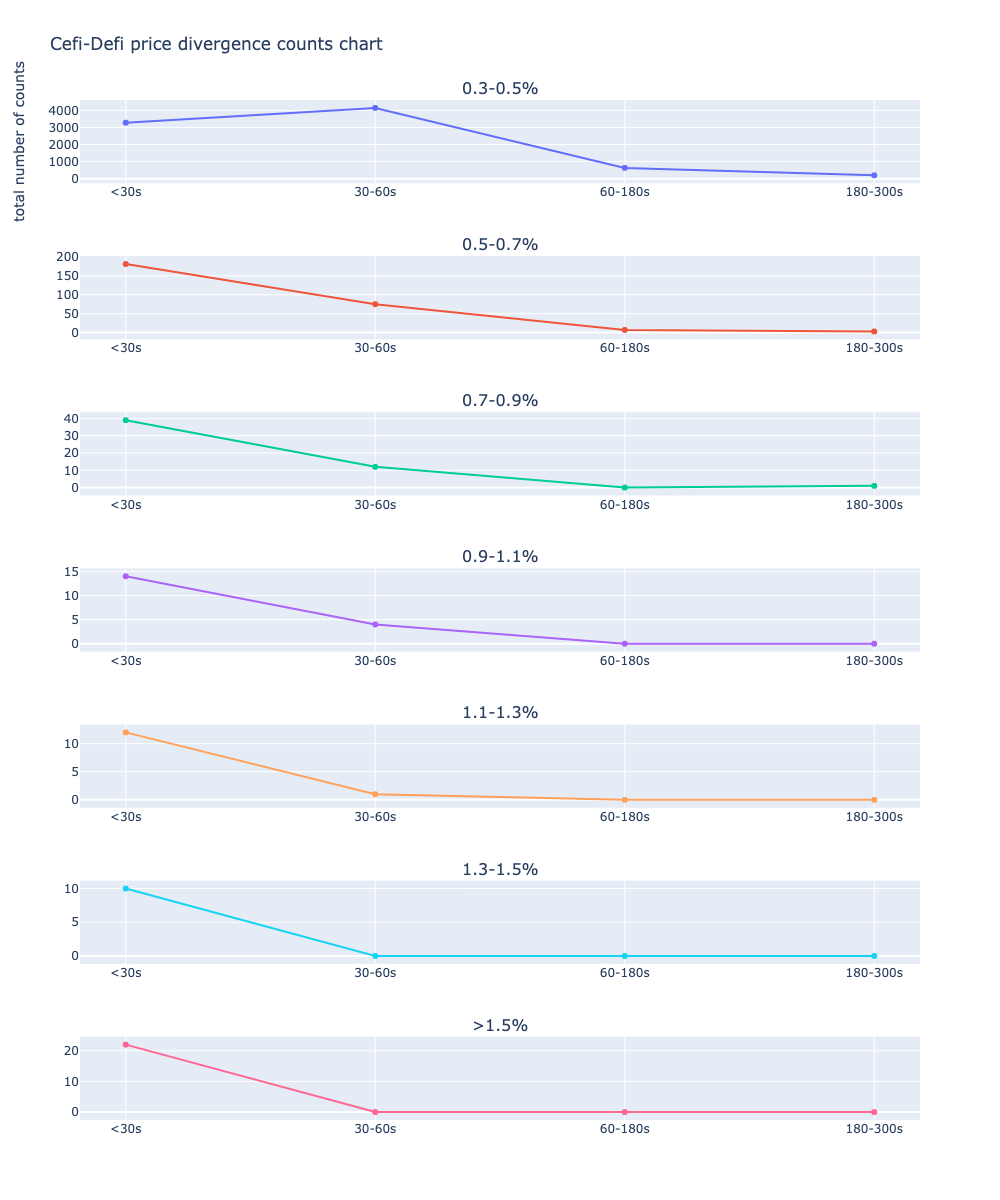

In [89]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=7, cols=1,
    subplot_titles=("0.3-0.5%","0.5-0.7%", "0.7-0.9%", "0.9-1.1%","1.1-1.3%","1.3-1.5%", ">1.5%")
                   )

df_n_column_names = ['<30s','30-60s','60-180s','180-300s','>300s']
fig.append_trace(go.Scatter(
    y = df_n['0.3 - 0.5'],
    x = df_n_column_names,

    showlegend=False
), row=1, col=1)
fig.append_trace(go.Scatter(
    y = df_n['0.5 - 0.7'],
    x = df_n_column_names,

    showlegend=False
), row=2, col=1)

fig.append_trace(go.Scatter(
    y = df_n['0.7 - 0.9'],
    x = df_n_column_names,
    showlegend=False
), row=3, col=1)

fig.append_trace(go.Scatter(
    y = df_n['0.9 - 1.1'],
    x = df_n_column_names,
   showlegend=False
), row=4, col=1)


fig.append_trace(go.Scatter(
    y = df_n['1.1 - 1.3'],
    x = df_n_column_names,
    showlegend=False 
), row=5, col=1)

fig.append_trace(go.Scatter(
    y = df_n['1.3 - 1.5'],
    x = df_n_column_names,
    showlegend=False 
), row=6, col=1)


fig.append_trace(go.Scatter(
    y = df_n['>1.5'],
    x = df_n_column_names,
    showlegend=False 
), row=7, col=1)

fig.update_layout(height= 1200, width=1000, title_text="Cefi-Defi price divergence counts chart",
                yaxis_title="total number of counts")
#fig.show()
fig.show("png")

# introduction to uniswap v2 equation:




#### given X * Y = K, Where x and y are pair reserves ( eth and usdc here)

#### When doing a swap, x and y are changed but k remains the same ( or grow slowly due to swap fee). 

#### We can write this formula


$
   (x + r \Delta X) (y - r \Delta X) = xy 
$

#### where r is 1 - swap fee ( 1 - 0.3%) = 0.997,  $ \Delta X$ is the amount we give in exchange for  $ \Delta y$, the amount we get.

#### the product of reserves after a swap must be equal to the product of reserves before the swap, which is the definition of constant product formula. We can use this formula to calculate the amount we get during swap.


#### after some basic algebraic operations: 

$
   \Delta Y = \frac{ ( y ＊  r \Delta  X)}{( x  +  r \Delta X)}
$


#### by using this formula, we can calculate amount out after swap of token x to token y

#### check this [reference]( https://betterprogramming.pub/uniswap-v2-in-depth-98075c826254) for detail

In [6]:

###############################################
# uniswap v2 swap amount equation function 
###############################################

#swap_amount_eth_to_usdc( eth_amountIn = 2,  usdc_reserve = 102819284 , eth_reserve = 27978, fee_tier = 0.003)

def swap_amount_eth_to_usdc( eth_amountIn,  usdc_reserve , eth_reserve , fee_tier = 0.003,):
    
    
    """ A function that uses uniswap equation above to calculate swap amount from eth to usdc """

    

    eth_amountInWithFee = eth_amountIn * ( 1 - fee_tier)

    numerator = eth_amountInWithFee * usdc_reserve
    denominator = eth_reserve + eth_amountInWithFee

    usdc_amount_out = numerator * 1.00 / denominator

    return usdc_amount_out


def swap_amount_usdc_to_eth( usdc_amountIn, usdc_reserve , eth_reserve, fee_tier = 0.003):
    
    """ A function that uses uniswap equation above to calculate swap amount from usdc to eth """


    usdc_amountInWithFee = usdc_amountIn * ( 1 - fee_tier)

    numerator = usdc_amountInWithFee * eth_reserve
    denominator = usdc_reserve + usdc_amountInWithFee

    eth_amount_out = numerator * 1.00 / denominator

    return eth_amount_out

## Simulate uniswap v2 swap amount impact on slippage:


In [90]:
df_merge = pd.read_csv('amber_merge_data_new.csv')


datetime: 2022-06-10 23:59:00 
eth pool price on v2 usdc/weth pair: 1670.4182280461116 
liquidity (K) : 3505245174705.0513 


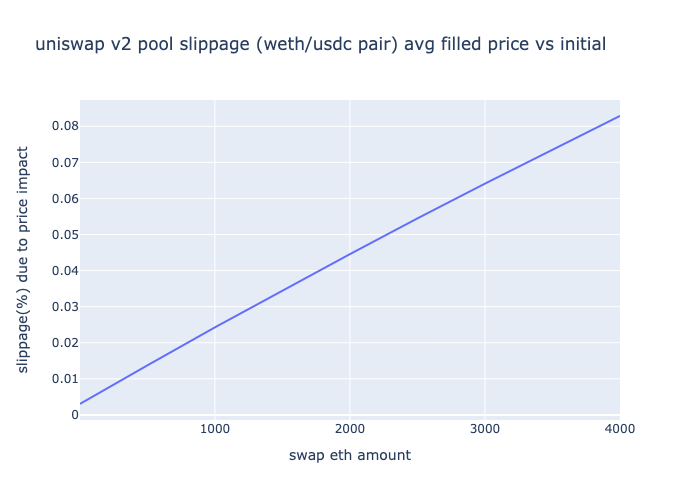

In [91]:
import plotly.express as px

eth_to_usdc = swap_amount_eth_to_usdc( eth_amountIn = 2,  usdc_reserve = 102819284 , eth_reserve = 27978, fee_tier = 0.003)


# based on differenc  eth swap amount to calculate price impact 
eth_amount = [1, 10, 50 , 100, 250 , 500, 1000, 1500, 2000, 2500, 3000,4000]
result = []
eth_initial_price = df_merge['dex_price'].iloc[-1]
liquidity = df_merge['token0Amount'].iloc[-1] * df_merge['token1Amount'].iloc[-1]
date_time = df_merge['datetime'].iloc[-1]

for eth in eth_amount:
    eth_to_usdc = swap_amount_eth_to_usdc( eth_amountIn = eth,  usdc_reserve = df_merge['token0Amount'].iloc[-1]
    ,eth_reserve = df_merge['token1Amount'].iloc[-1], fee_tier = 0.003)
    avg_filled_price_per_eth = eth_to_usdc / eth
    
    
    percent = ( eth_initial_price - avg_filled_price_per_eth)  / eth_initial_price
    
    result.append([eth_initial_price, liquidity, eth, percent ])
    


result_df = pd.DataFrame( result ,columns=['eth_initial_price','liquidity','eth_amount','price_diff'])  






print(f"datetime: { date_time} ")
print(f"eth pool price on v2 usdc/weth pair: { eth_initial_price} ")
print(f"liquidity (K) : { liquidity} ")



fig = px.line( result_df, x="eth_amount", y="price_diff", 
                labels ={
                     "price_diff": "slippage(%) due to price impact",
                     "eth_amount": "swap eth amount"
                 },
              title= f'uniswap v2 pool slippage (weth/usdc pair) avg filled price vs initial')
fig.show("png")






# Design defi/cefi arbitrage strategy framework

### get historical gas fee by leveraging amberdata API

In [92]:

import importlib
import dotenv
importlib.reload(dotenv)
from dotenv import load_dotenv # use for api key 
import os #provides ways to access the Operating System and allows us to read the environment variables


In [95]:



################################
# load api key from .env file 
################################

load_dotenv()

my_secret_key = os.getenv("AMBER_DATA_API_SECRET_KEY_n")


################################
# get historical gas fee 
################################


headers = {
    "Accept": "application/json",
    "x-api-key": my_secret_key
}


# gas_fee_api(1578531600)

def gas_fee_api(time_stamp):

    url = f"https://web3api.io/api/v2/transactions/gas/percentiles?timestamp={time_stamp}"

    response = requests.get(url, headers=headers)
    response = json.loads(response.text)

    try:
        gas_fee_in_wei_per_TX = response['payload']['percentile_080']
        gas_fee_in_eth_per_TX = gas_fee_in_wei_per_TX * 10**(-18)

    except:
        gas_fee_in_eth_per_TX = -1

    return gas_fee_in_eth_per_TX


if __name__ == '__main__':


    my_secret_key = os.getenv("AMBER_DATA_API_SECRET_KEY_n")

    #print(f'My secret key is: {my_secret_key}.')
        
    
    print(gas_fee_api(1578531600))
      



1.5000000000000002e-08


## Strategy codebase 

In [96]:
import pandas as pd
from datetime import datetime
from enum import Enum
import time
import uniswap_v2_equation_update as uni




class Mode(Enum):
    BACKTEST = "BACKTEST"
    LIVE = "LIVE"


class Position(Enum):
    LONG = 0
    SHORT = 1


class StrategyBase_notebook:
    def __init__(self, params):
        self.df = None
        self.mode = None
        self.do_print = None

        self.params = params
        self.order_amount = None
        self.signal = 0
        self.buy_symbol = None
        self.sell_symbol = None
        self.buy_quote_amount = None
        self.sell_quote_amount = None
        self.row = None
        self.price_diff = None
        self.df_record = pd.DataFrame()
        self.pnl = None
        self.trade_num = 0
        self.status = 0

        # gas parameters add here
        self.gas_fee = None
        self.gas_fee_uniswap_usd = None
        self.wei_transfer_to_uniswap_fee_usd = 600000


        # slippage parameters add here
        self.cex_buy_slippage = 1.001
        self.cex_sell_slippage = 0.999




        # avg filled price between dex and cex
        self.avg_filled_cex_price = None
        self.avg_filled_dex_price = None
        
        # 30% slippage for prfoit
        self.overall_slippage_factor = 1


    def log(self, txt):
        if self.do_print:
            print(txt)

    def historical_data_feed(self, df):
        self.df = df

    def live_data_feed(self):
        pass

    def broker(self):
        if self.mode == Mode.BACKTEST:
            if self.signal == 1:

                #########################################
                # place your trade logic here
                #########################################



                per_trade_usdc_on_hand = self.params['order_quote_amount'] * 0.8

                if self.buy_symbol == 'cex':
                    
                # if buy_symbol == cex
                # usdc buy eth on cex, sell on dex (borrow eth and sell)

                    #######################################
                    # buy eth on cex
                    #######################################
                    self.avg_filled_cex_price = self.row['cex_price'] * self.cex_buy_slippage
                    self.order_amount = per_trade_usdc_on_hand / self.avg_filled_cex_price
                    self.buy_quote_amount = self.order_amount * self.avg_filled_cex_price

                    #######################################
                    # sell eth on dex
                    #######################################
                    # we know the amount of eth to sell from cex
                    eth_to_usdc_from_dex = uni.swap_amount_eth_to_usdc(eth_amountIn= self.order_amount,
                                                                   usdc_reserve= self.row['token0Amount'],
                                                                   eth_reserve= self.row['token1Amount'],
                                                                    fee_tier = 0.003)

                    self.avg_filled_dex_price = eth_to_usdc_from_dex / self.order_amount
                    self.sell_quote_amount = self.order_amount * self.avg_filled_dex_price

                elif self.buy_symbol == 'dex':

                # if buy_symbol = dex 
                # usdc buy eth on dex, sell eth on cex (borrow eth and sell)
                    

                    #########################################
                    # usdc buy eth on dex
                    #########################################
                    
                    # swap usdc for eth on uniswap 
                    usdc_to_eth_from_dex = uni.swap_amount_usdc_to_eth( usdc_amountIn = per_trade_usdc_on_hand ,
                                                                        usdc_reserve = self.row['token0Amount'],
                                                                        eth_reserve = self.row['token1Amount'],
                                                                        fee_tier=0.003)
                    
                    
                    self.order_amount = usdc_to_eth_from_dex
                    self.avg_filled_dex_price =  per_trade_usdc_on_hand /  usdc_to_eth_from_dex
                    self.buy_quote_amount = self.order_amount * self.avg_filled_dex_price

                    #########################################
                    # sell eth on cex
                    #########################################

                    self.avg_filled_cex_price = self.row['cex_price'] * self.cex_sell_slippage
                    self.sell_quote_amount = self.order_amount * self.avg_filled_cex_price



                #print(f'{self.buy_symbol}: + base  {self.order_amount}, - quote  {self.buy_quote_amount}')
                #print(f'{self.sell_symbol}: - base  {self.order_amount}, + quote  {self.sell_quote_amount}')


# calculate PnL per trade
    def account(self):
        if self.signal == 1:
            
            
            #########################################################
            # calculate PnL based on trade logic (in function broker)
            #########################################################



            if self.buy_symbol == 'cex':
                pnl = self.sell_quote_amount - self.buy_quote_amount - self.gas_fee_uniswap_usd * 2

            elif self.buy_symbol == 'dex':
                pnl = self.sell_quote_amount - self.buy_quote_amount - self.gas_fee_uniswap_usd * 1 

            self.pnl = pnl * self.overall_slippage_factor



    def record(self):
        row = self.row
        if self.signal == 1:
            if self.buy_symbol == 'cex':
                cex_base_amount = self.order_amount
                cex_quote_amount = -self.buy_quote_amount
                dex_base_amount = -self.order_amount
                dex_quote_amount = self.sell_quote_amount
            elif self.buy_symbol == 'dex':
                dex_base_amount = self.order_amount
                dex_quote_amount = -self.buy_quote_amount
                cex_base_amount = -self.order_amount
                cex_quote_amount = self.sell_quote_amount
        elif self.signal == 0:
            dex_base_amount = dex_quote_amount = cex_base_amount = cex_quote_amount = None

        new_df = pd.DataFrame(data={
            'timestamp': [row['timestamp']],
            'datetime': [row['datetime']],
            'dex_token_0_amount': [row['token0Amount']],
            'dex_token_1_amount': [row['token1Amount']],
            'cex_price': [row['cex_price']],
            'dex_price': [row['dex_price']],
            'price_diff(%)': [self.price_diff],
            'cex_base_amount': [cex_base_amount],
            'cex_quote_amount': [cex_quote_amount],
            'dex_base_amount': [dex_base_amount],
            'dex_quote_amount': [dex_quote_amount],
            'avg_filled_cex_price':[self.avg_filled_cex_price],
            'avg_filled_dex_price': [self.avg_filled_dex_price],
            'gas_fee_per_TX_eth_amount': [self.gas_fee],
            'gas_fee_uniswap_usd_amount': [self.gas_fee_uniswap_usd],
            'pnl': self.pnl
        })

        self.df_record = pd.concat([self.df_record, new_df], ignore_index=False)

        if self.signal == 1:
            print(new_df)
            print(self.gas_fee)

    def output_record(self):
        df = self.df_record
        #print(df.columns)
        df['price_diff(%)'] = df['price_diff(%)'] * 100
        df['entry'] = (df['price_diff(%)'] > self.params['price_diff']) & (df['price_diff(%)'].shift() < self.params['price_diff'])
        df['exit'] = (df['price_diff(%)'] < self.params['price_diff']) & (df['price_diff(%)'].shift() > self.params['price_diff'])

        df = df.reset_index(drop=True)

        df = df[['timestamp', 'datetime', 'entry','exit','dex_token_0_amount','dex_token_1_amount',
            'price_diff(%)','cex_price', 'dex_price','avg_filled_cex_price', 'avg_filled_dex_price',
            'cex_base_amount', 'cex_quote_amount', 'dex_base_amount',
            'dex_quote_amount', 'gas_fee_per_TX_eth_amount',
            'gas_fee_uniswap_usd_amount', 'pnl']]


        df.to_csv('output/trade_record.csv')

    def reset_params(self):
        if self.signal == 1:
            self.trade_num += 1

        self.signal = 0
        self.buy_symbol = None
        self.sell_symbol = None
        self.buy_quote_amount = None
        self.sell_quote_amount = None

        self.price_diff = None
        self.pnl = None

        self.order_amount = self.params['order_quote_amount'] * 0.8 / self.row['cex_price']

        # defi parameters added here
        self.gas_fee = None
        self.gas_fee_uniswap_usd = None

        # fill_Ed
        self.avg_filled_cex_price = None
        self.avg_filled_dex_price = None




    def condition(self):
        pass

    def loop(self):
        self.reset_params()
        self.condition()
        self.broker()
        self.account()
        self.record()

    def run(self, mode=Mode, do_print=True):
        self.do_print = do_print
        self.mode = mode

        if mode == Mode.BACKTEST:
            for index, row in self.df.iterrows():
                self.row = row
                self.loop()
            self.output_record()

        elif mode == Mode.LIVE:
            while True:
                self.row = self.live_data_feed()
                self.loop()
                self.output_record()
                time.sleep(5)

## Customize buy/sell signal and bet amount here 

In [98]:
import pandas as pd
from importlib import reload
import uniswap_v2_equation_update as uni
reload(uni)
import time




class Example_Strategy(StrategyBase_notebook):
    def condition(self):
        #print(self.row.to_dict())
        row = self.row
        cex_price = row['cex_price']
        dex_price = row['dex_price']

        price_diff = abs(cex_price-dex_price) / min(cex_price,dex_price)

        timestamp = int(row['timestamp'])


        self.price_diff = price_diff

        if price_diff > self.params['price_diff'] * 0.01:
            
            # buy cex, sell dex
            # if buy_symbol = cex => usdc buy eth on cex, sell on dex (borrow eth and sell)
            # if buy_symbol = dex => usdc buy on dex, sell on cex (borrow eth and sell)

            if min(cex_price,dex_price) == cex_price:
                buy_symbol = 'cex'
                sell_symbol = 'dex'

            # buy dex, sell cex
            elif min(cex_price,dex_price) == dex_price:

                buy_symbol = 'dex'
                sell_symbol = 'cex'

            ###################################
            # get historical gas fee 
            ###################################
            
            trade_gas_fee_in_eth_per_TX_in_eth = gas_fee_api(timestamp)
            trade_gas_fee_in_usd = trade_gas_fee_in_eth_per_TX_in_eth * cex_price * self.wei_transfer_to_uniswap_fee_usd

            self.signal = 1
            self.buy_symbol = buy_symbol
            self.sell_symbol = sell_symbol
            self.gas_fee = trade_gas_fee_in_eth_per_TX_in_eth
            self.gas_fee_uniswap_usd = trade_gas_fee_in_usd



    def loop(self):
        self.reset_params()
        self.condition()
        self.broker()
        self.account()
        self.record()

        
        
        
if __name__ == '__main__':
     
    
    #######################################
    # input your trade parameters here 
    #######################################
    
    
    start_time = time.time()

    params = {
        'price_diff': 1.2, # the entry signal in percentage for aribtrage
        'order_base_amount': 1, 
        'order_quote_amount': 100000 # inital capital on each side(dex,cex), the total capital will be order_quote_amount*2 
    }


    historical_data = pd.read_csv('amber_merge_data_new.csv')
    
    
    start = datetime(2022, 5, 14, 0, 0, 0)
    end = datetime(2022, 6, 11, 0, 0, 0)
    
    historical_data_part = historical_data.loc[(historical_data['timestamp'] > start.timestamp()*1000) & (historical_data['timestamp'] < end.timestamp()*1000)]
    historical_data_part = historical_data_part.drop_duplicates(subset=['timestamp'], keep='last')


    # start the strategy object 
    arb_strat = Example_Strategy(params=params)
    # feed historical data
    arb_strat.historical_data_feed(historical_data_part)  
    # run the strategy 
    arb_strat.run(mode=Mode.BACKTEST)

    print(f'time spent on backtesting {time.time()- start_time}')




       timestamp             datetime  dex_token_0_amount  dex_token_1_amount  \
0  1652644500000  2022-05-15 15:55:00        1.027293e+08        47334.700824   

     cex_price    dex_price  price_diff(%)  cex_base_amount  cex_quote_amount  \
0  2091.290749  2170.274339       0.037768        38.215671          -80000.0   

   dex_base_amount  dex_quote_amount  avg_filled_cex_price  \
0       -38.215671      82623.169669            2093.38204   

   avg_filled_dex_price  gas_fee_per_TX_eth_amount  \
0           2162.023243               2.364970e-08   

   gas_fee_uniswap_usd_amount          pnl  
0                   29.675043  2563.819582  
2.3649703191400006e-08
       timestamp             datetime  dex_token_0_amount  dex_token_1_amount  \
0  1652716610000  2022-05-16 11:56:50        9.838119e+07        49427.732513   

     cex_price    dex_price  price_diff(%)  cex_base_amount  cex_quote_amount  \
0  2015.946326  1990.404665       0.012832       -40.039792      80637.353779   

 

       timestamp             datetime  dex_token_0_amount  dex_token_1_amount  \
0  1653757020000  2022-05-28 12:57:00        7.853060e+07        44658.009172   

     cex_price    dex_price  price_diff(%)  cex_base_amount  cex_quote_amount  \
0  1781.084866  1758.488513        0.01285       -45.311114       80622.23652   

   dex_base_amount  dex_quote_amount  avg_filled_cex_price  \
0        45.311114          -80000.0           1779.303781   

   avg_filled_dex_price  gas_fee_per_TX_eth_amount  \
0           1765.571245               2.059451e-08   

   gas_fee_uniswap_usd_amount         pnl  
0                   22.008347  600.228173  
2.0594514168000003e-08
       timestamp             datetime  dex_token_0_amount  dex_token_1_amount  \
0  1653758231000  2022-05-28 13:17:11        7.846550e+07        44699.786646   

     cex_price    dex_price  price_diff(%)  cex_base_amount  cex_quote_amount  \
0  1780.238975  1755.388783       0.014157       -45.391088      80726.176727   

   

       timestamp             datetime  dex_token_0_amount  dex_token_1_amount  \
0  1654878524000  2022-06-10 12:28:44        7.646931e+07        45820.990821   

     cex_price    dex_price  price_diff(%)  cex_base_amount  cex_quote_amount  \
0  1691.922241  1668.870691       0.013813       -47.743001      80696.667096   

   dex_base_amount  dex_quote_amount  avg_filled_cex_price  \
0        47.743001          -80000.0           1690.230319   

   avg_filled_dex_price  gas_fee_per_TX_eth_amount  \
0           1675.638293               6.620641e-08   

   gas_fee_uniswap_usd_amount         pnl  
0                   67.209654  629.457442  
6.620640548000001e-08
       timestamp             datetime  dex_token_0_amount  dex_token_1_amount  \
0  1654882221000  2022-06-10 13:30:21        7.616538e+07        46011.847484   

     cex_price    dex_price  price_diff(%)  cex_base_amount  cex_quote_amount  \
0  1688.732479  1655.342893       0.020171       -48.132966      81202.419212   

   d

In [99]:
historical_data_part

,Unnamed: 0,timestamp,cex_price,dex_price,token0Amount,token1Amount,datetime
329370,193665,1652500860000,2049.285027,2044.730631,9.966593e+07,48742.816530,2022-05-14 00:01:00
329371,193666,1652500920000,2046.718294,2044.730631,9.966593e+07,48742.816530,2022-05-14 00:02:00
329372,193667,1652500980000,2046.405989,2044.730631,9.966593e+07,48742.816530,2022-05-14 00:03:00
329373,638328,1652501010000,2046.405989,2044.779097,9.966711e+07,48742.239882,2022-05-14 00:03:30
329374,193668,1652501040000,2046.417025,2044.779097,9.966711e+07,48742.239882,2022-05-14 00:04:00
...,...,...,...,...,...,...,...
424222,714729,1654919873000,1669.260519,1670.399138,7.651900e+07,45808.813283,2022-06-10 23:57:53
424223,714730,1654919877000,1669.260519,1670.348007,7.651783e+07,45809.515454,2022-06-10 23:57:57
424224,234377,1654919880000,1669.768650,1670.348007,7.651783e+07,45809.515454,2022-06-10 23:58:00
424225,714732,1654919928000,1669.768650,1670.418228,7.651944e+07,45808.554721,2022-06-10 23:58:48


## Show all transactions in table 

In [11]:
historical_data_strategy = pd.read_csv('output/trade_record.csv')

historical_data_strategy.head()

,Unnamed: 0,timestamp,datetime,entry,exit,dex_token_0_amount,dex_token_1_amount,price_diff(%),cex_price,dex_price,avg_filled_cex_price,avg_filled_dex_price,cex_base_amount,cex_quote_amount,dex_base_amount,dex_quote_amount,gas_fee_per_TX_eth_amount,gas_fee_uniswap_usd_amount,pnl
0,0,1652500860000,2022-05-14 00:01:00,False,False,9.966593e+07,48742.816530,0.222738,2049.285027,2044.730631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1652500920000,2022-05-14 00:02:00,False,False,9.966593e+07,48742.816530,0.097209,2046.718294,2044.730631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1652500980000,2022-05-14 00:03:00,False,False,9.966593e+07,48742.816530,0.081935,2046.405989,2044.730631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1652501010000,2022-05-14 00:03:30,False,False,9.966711e+07,48742.239882,0.079563,2046.405989,2044.779097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1652501040000,2022-05-14 00:04:00,False,False,9.966711e+07,48742.239882,0.080103,2046.417025,2044.779097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Show only the part that the strategy trades 

In [100]:
historical_data_strategy = pd.read_csv('output/trade_record.csv')

historical_data_strategy.head()


###################################
# show all trades being placed
###################################

historical_data_strategy= historical_data_strategy[ historical_data_strategy['entry']==True]

#historical_data_strategy= historical_data_strategy[ ~ historical_data_strategy['pnl'].isna()]
historical_data_strategy_concise = historical_data_strategy[['datetime','price_diff(%)',
                                    'cex_price', 'dex_price', 'avg_filled_cex_price', 'avg_filled_dex_price',
                                     'cex_base_amount', 'cex_quote_amount','dex_base_amount', 'dex_quote_amount',
                                    'gas_fee_uniswap_usd_amount', 'entry','exit','pnl']]

                                                                    
historical_data_strategy_concise

,datetime,price_diff(%),cex_price,dex_price,avg_filled_cex_price,avg_filled_dex_price,cex_base_amount,cex_quote_amount,dex_base_amount,dex_quote_amount,gas_fee_uniswap_usd_amount,entry,exit,pnl
5948,2022-05-15 15:55:00,3.776787,2091.290749,2170.274339,2093.382040,2162.023243,38.215671,-80000.000000,-38.215671,82623.169669,29.675043,True,False,2563.819582
8763,2022-05-16 11:56:50,1.283240,2015.946326,1990.404665,2013.930380,1998.012371,-40.039792,80637.353779,40.039792,-80000.000000,43.730391,True,False,593.623389
8787,2022-05-16 12:05:31,1.235895,2012.504512,1987.935721,2010.492008,1995.534956,-40.089501,80599.620742,40.089501,-80000.000000,52.748774,True,False,546.871967
27520,2022-05-22 07:38:31,1.965629,2015.093153,2054.702412,2017.108247,2046.525061,39.660737,-80000.000000,-39.660737,81166.692529,19.156956,True,False,1128.378618
42200,2022-05-26 04:21:00,1.222641,1881.954246,1904.963784,1883.836200,1897.329479,42.466537,-80000.000000,-42.466537,80573.012804,31.105651,True,False,510.801501
42202,2022-05-26 04:21:35,1.348208,1881.954246,1856.919113,1880.072292,1864.393814,-42.909389,80672.753890,42.909389,-80000.000000,31.514107,True,False,641.239782
43245,2022-05-26 10:20:46,1.938329,1837.452001,1873.067859,1839.289453,1865.531519,43.495057,-80000.000000,-43.495057,81141.400170,87.095225,True,False,967.209721
43255,2022-05-26 10:23:50,1.786443,1848.509580,1881.532141,1850.358090,1873.969072,43.234875,-80000.000000,-43.234875,81020.817857,91.068906,True,False,838.680046
50547,2022-05-28 12:56:05,1.408941,1781.836804,1757.080580,1780.054968,1764.158385,-45.347402,80720.868705,45.347402,-80000.000000,21.543751,True,False,699.324954
50550,2022-05-28 12:56:53,1.327748,1781.836804,1758.488513,1780.054968,1765.571245,-45.311114,80656.273620,45.311114,-80000.000000,22.017638,True,False,634.255982


# Strategy Dashboard with PnL 

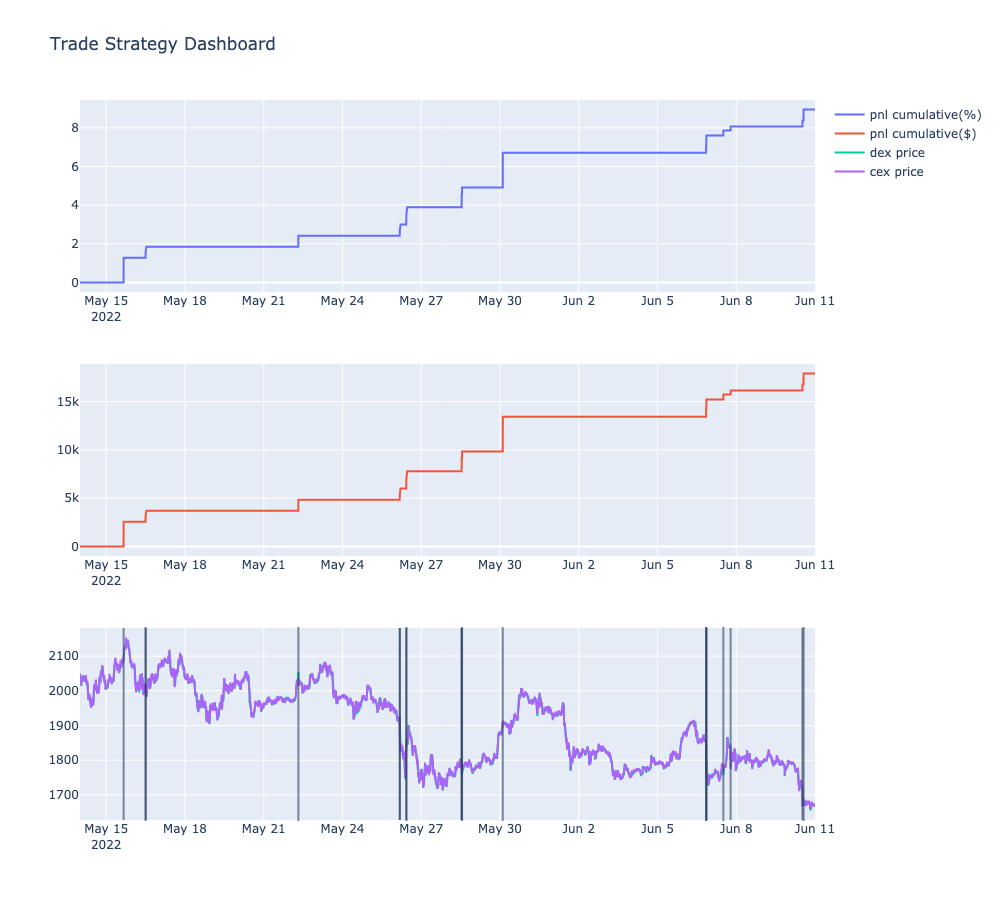

In [101]:
import pandas as pd
import numpy as np
from datetime import datetime
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# edit bet amount here 
total_bet_amount = 200000

# if entry => calculate profit, else not consider

def resample_dataframe(df, step):
    
    """ A helper function that build metrics for dashboard visualization """

    df['datetime'] = df['timestamp'].apply(lambda x: datetime.fromtimestamp(x/1000))
    df['cum_pnl'] = df.apply(lambda x: x['pnl'] if x['entry'] else 0, axis=1)
    df['cum_pnl'] = df['cum_pnl'].cumsum()
    df['cum_pnl(%)'] = 100 * df['cum_pnl'] / total_bet_amount 
    df_resample = df.iloc[::step]
    return  df_resample


def subplot(df):
    fig = make_subplots(rows=3, cols=1)
    
    fig.add_trace(go.Scatter(
        x=df['datetime'],
        y=df['cum_pnl(%)'],
        name="pnl cumulative(%)"

    ), row=1, col=1)
        
    fig.add_trace(go.Scatter(
        x=df['datetime'],
        y=df['cum_pnl'],
        name="pnl cumulative($)"
    ), row=2, col=1)

    fig.add_trace(go.Scatter(
        x=df_resample['datetime'],
        y=df_resample['dex_price'],
        name="dex price"

    ), row=3, col=1)

    fig.add_trace(go.Scatter(
        x=df_resample['datetime'],
        y=df_resample['cex_price'],
        name="cex price"
    ), row=3, col=1)
    return fig


def background_color(df, fig):
    df['signal'] = df.apply(lambda x: 'entry' if x['entry'] else ('exit' if x['exit'] else np.nan), axis=1)
    df = df[['datetime', 'cex_price', 'dex_price', 'price_diff(%)', 'signal']]

    entry_list = df.loc[df['signal'] == 'entry'].datetime.tolist()
    exit_list = df.loc[df['signal'] == 'exit'].datetime.tolist()
    if len(exit_list) == len(entry_list) + 1:
        exit_list.append(df.datetime.values[-1])
    #print(range(len(entry_list)))
    for i in range(len(entry_list)):
        #print(i)
        fig.add_vrect(x0=entry_list[i], x1=exit_list[i], fillcolor="#2E4053", opacity=0.6, line_width= 2, row=3, col=1)
    
    return fig


if __name__ == '__main__':
    df = pd.read_csv('output/trade_record.csv', index_col=0)
    df_resample = resample_dataframe(df, step=10)

    fig = subplot(df_resample)
    fig = background_color(df, fig)
    
    fig.update_layout(height= 900, width=1000, title_text=" Trade Strategy Dashboard")

    #fig.show(config={'scrollZoom': True})


    fig.show("png",config={'scrollZoom': True})
    fig.write_html('output/strategy performance chart.html')
    
    
    

# Trade statistics summary ( with gas fee)

- show every trade pnl with gas fee and entry time 

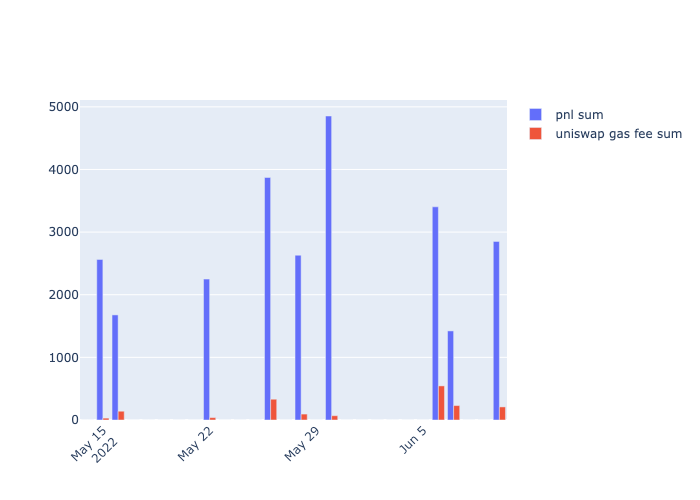

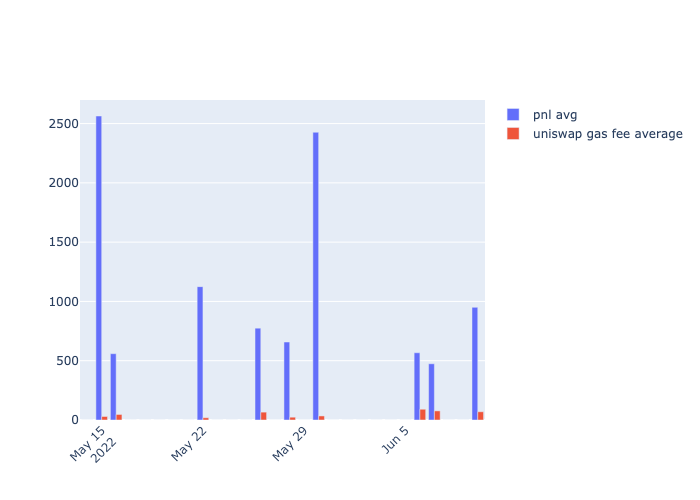

In [102]:
import pandas as pd
import plotly.graph_objects as go

# change freq for the bar chart : 2h or 1d 
# edit df.groupby function 
#freq_selector = "1d" 
freq_selector = "1d" 

# groupby date data
def groupby_date_data(df):
    df['datetime'] = pd.to_datetime(df['datetime'])

    group_df = df.groupby(pd.Grouper(key='datetime', axis=0, freq= freq_selector)).agg(
        gas_sum=('gas_fee_uniswap_usd_amount', 'sum'),
        gas_avg=('gas_fee_uniswap_usd_amount', 'mean'),
        pnl_sum=('pnl', 'sum'),
        pnl_avg=('pnl', 'mean')
    )
    group_df = group_df.fillna(0)
    #group_df = group_df.dropna()
    return group_df

# plot sum
def plot_sum(group_df, file_name):
    date = group_df.index.tolist()

    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=date,
        y=group_df['pnl_sum'],
        name='pnl sum'
    ))
    fig.add_trace(go.Bar(
        x=date,
        y=group_df['gas_sum'],
        name='uniswap gas fee sum'
    ))
    fig.update_layout(barmode='group', xaxis_tickangle=-45)
    #fig.show(config={'scrollZoom': True})

    fig.show("png",config={'scrollZoom': True})
    #fig.write_html(f'{file_name}.html')


# plot avg
def plot_avg(group_df, file_name):
    date = group_df.index.tolist()

    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=date,
        y=group_df['pnl_avg'],
        name='pnl avg'
    ))
    fig.add_trace(go.Bar(
        x=date,
        y=group_df['gas_avg'],
        name='uniswap gas fee average'
    ))

    fig.update_layout(barmode='group', xaxis_tickangle=-45)
    #fig.show(config={'scrollZoom': True})

    fig.show("png",config={'scrollZoom': True})
    #fig.write_html(f'{file_name}.html')


if __name__=="__main__":
    df = pd.read_csv('output/trade_record.csv')
    groupby_df = groupby_date_data(df)
    plot_sum(groupby_df, 'output/all_trades_sum')
    plot_avg(groupby_df, 'output/all_trades_avg')
    
    
    

## Calculate Sharp/Sortino/SQN 

In [103]:
pnl_list = np.array(groupby_df['pnl_avg'])
equity = 200000 + np.cumsum(pnl_list)
return_ = np.diff(equity) / equity[:-1]
return_ = pd.Series(return_)

def system_quality_number(pnl):
    trade_num = len(pnl[pnl != 0])
    pnl_loss = pnl[pnl < 0]
    avg_loss = np.sum(pnl_loss) / len(pnl_loss)
    r_multiples = pnl / -avg_loss
    r_expectancy = np.mean(r_multiples)
    r_std = np.std(r_multiples)
    sqn = (r_expectancy / r_std) * trade_num ** 0.5
    return sqn

sharpe_ratio = qs.stats.sharpe(returns=return_, rf=0, periods=365)
# Sortino_Ratio = qs.stats.sortino(returns=return_, rf=0, periods=365)
# SQN = system_quality_number(pnl_list)

print(f"the strategy sharp ratio is: {sharpe_ratio} " )
# print(sortino_ratio)
# print(SQN)

the strategy sharp ratio is: 10.149192823246096 
